# Import libraries

In [16]:
# General libraries
import numpy as np
import h5py
import os

# Parallelisation libraries
from joblib import Parallel, delayed

# Module functions
import ximinf.selection_effects as se
import ximinf.generate_sim as gsim

# Plot libraries
import matplotlib.pyplot as plt

In [17]:
num_threads = os.cpu_count()
print(f"Number of threads: {num_threads}")

Number of threads: 48


# Generation of SN Ia samples in parallel

In [18]:
# -------- User parameters --------

N = 10_000 # Number of samples 100_000
M = 1000 #1000 # Number of SNe per sample #3_000

# ---------------------------------

ranges = {
    'mabs': (-21, -18), #(-19.5, -19.0),
    'alpha_low': (-0.5,0), #(-0.5, -0.0),
    'alpha_high': (-0.3,0.2), #(-0.5, -0.0),
    'beta': (2.5,4), #(2.0, 4.0),
    'gamma': (-0.1,0.4), #(0.0, 0.3)
    'sigma_int': (0.0, 0.3),
}

types = {
    'mabs': 'gaussian',         # Uniform in [-21, -18]
    'alpha_low': 'gaussian',
    'alpha_high': 'gaussian',
    'beta': 'gaussian',
    'gamma': 'gaussian',
    'sigma_int': 'half-gaussian',  # Positive, includes zero
}

priors = {name: {'range': np.array(ranges[name], dtype=np.float32), 'type': types[name]}
          for name in ranges.keys()}

# columns = ['magobs', 'magobs_err','x1', 'x1_err', 'c', 'c_err', 'prompt', 'localcolor', 'localcolor_err', 'mass', 'mass_err', 'z']
columns = ['magobs', 'magobs_err','x1', 'x1_err', 'c', 'c_err', 'localcolor', 'localcolor_err', 'z']

n_realisation = 3

print('Sampling parameters...')
params_dict = gsim.scan_params(priors, N, n_realisation)
print("... done")

N_total = N*n_realisation



Sampling parameters...
... done


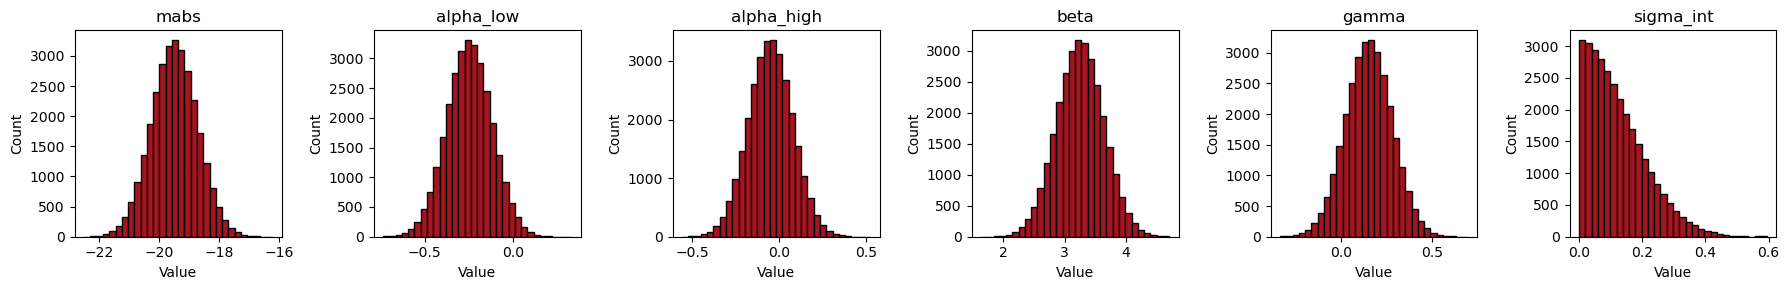

In [19]:
colors = ['#A31621', '#1F487E', '#C07835']

# Create subplots
fig, axes = plt.subplots(1, len(params_dict), figsize=(3*len(params_dict),3))

for ax, (key, values) in zip(axes, params_dict.items()):
    ax.hist(values, bins=30, color=colors[0], edgecolor='black')  # you can cycle colors if you want
    ax.set_title(key)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [20]:
print("Running parallel simulations...")

# with parallel_backend("threading"):
results = Parallel(n_jobs=min(N_total//20, num_threads-2))(
    delayed(gsim.simulate_one)(
        {k: v[i] for k, v in params_dict.items()},
        z_max=0.06,
        M=M,
        cols=columns,
        N=N_total,
        i=i
    )
    for i in range(N_total)
)

print("... done")

Running parallel simulations...
... doneon 30000/30000


# Apply selection effects

In [21]:
# # Applying selection effect
# print('Applying selection effect...')
# m_lim = 19.5
# results = se.malmquist_bias_batch(results, m_lim, M, columns)
# print('...done')

# Plot the first sample

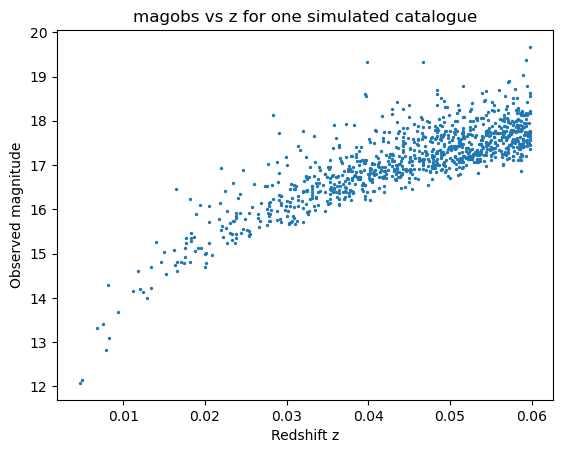

Number of SNe after selection: 1000


In [22]:
# Take one simulation
example = results[1]

# Convert columns to NumPy arrays for easier indexing
magobs = np.array(example['magobs'])
z      = np.array(example['z'])

# Apply selection (magobs > 0)
mask = magobs > 0
magobs_cut = magobs[mask]
z_cut = z[mask]

# Plot
plt.figure()
plt.scatter(z_cut, magobs_cut, s=2)
plt.xlabel("Redshift z")
plt.ylabel("Observed magnitude")
plt.title("magobs vs z for one simulated catalogue")
plt.show()

# Number of SNe after selection
print('Number of SNe after selection:', len(magobs_cut))


# Save data to disk

## Build a dict of big arrays

In [23]:
dict_arrays = {col: np.zeros((N_total, M), dtype=np.float32) for col in columns}

for i, sim_data in enumerate(results):  # sim_data is just the dict returned by simulate_one
    for col, arr in sim_data.items():   # arr is a list of length M
        dict_arrays[col][i, :] = arr   # fill row i

## Estimate size

In [24]:
# Data size in bytes
total_bytes = sum(arr.nbytes for arr in dict_arrays.values())

# Parameters size in bytes
total_bytes += sum(arr.nbytes for arr in params_dict.values())

# Convert to MB
size_MB = total_bytes / (1024**2)
print(f"Estimated size on disk: {size_MB:.2f} MB")

Estimated size on disk: 1030.65 MB


## Save

In [25]:
save_path = "../data/SIM/simulations.h5"

with h5py.File(save_path, "w") as f:
    # Save parameters
    for key, arr in params_dict.items():  # each arr has shape (N,)
        f.create_dataset(f"params/{key}", data=arr, dtype=np.float32)
    
    # Save data columns
    for col, arr in dict_arrays.items():  # each arr has shape (N, M)
        f.create_dataset(f"data/{col}", data=arr, dtype=np.float32)
    
    # Save priors
    priors_grp = f.create_group("priors")
    for name, prior in priors.items():
        param_grp = priors_grp.create_group(name)
        param_grp.create_dataset("range", data=prior['range'])
        param_grp.attrs['type'] = prior['type']